In [1]:
%%html
<style>.container {width: 80% !important;}</style>

In [2]:
import torch
import gc
from torch import nn
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def flush():
  gc.collect()
  torch.cuda.empty_cache()

## Create parameters

In [4]:
n_classes = 21
batch_size = 4
learning_rate = 1e-4
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Get dataset and creat train and test loader

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
test_images_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='val')
train_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='train', transform=image_transform, target_transform=mask_transform)
test_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='val', transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


## Show some random images

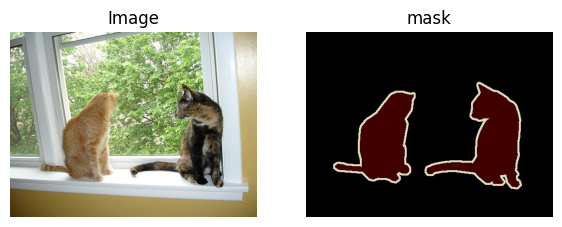

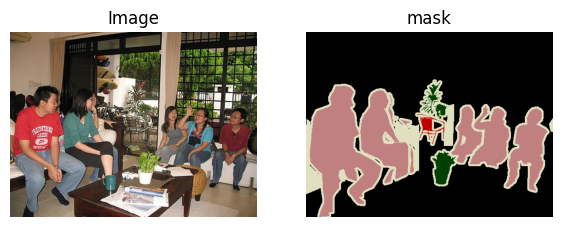

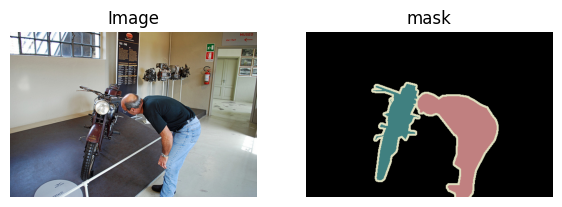

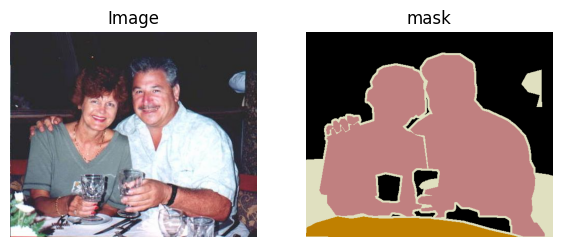

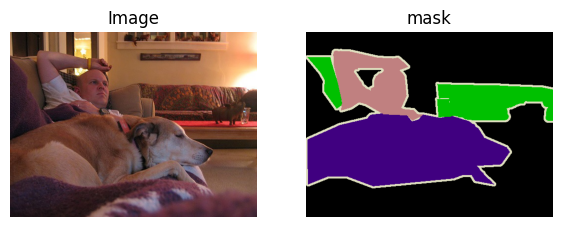

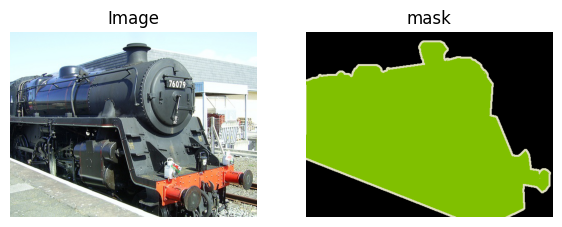

In [46]:
rand_ids = np.random.randint(0, len(test_images_data), 6)
for id in rand_ids:
    image, mask = test_images_data[id]
#     print(image.shape)
#     image = image.permute(1, 2, 0)
#     mask = mask.squeeze()
    fig, axis = plt.subplots(1,2,figsize = (7, 4))
    axis[0].imshow(image)
    axis[0].set_title("Image")
    axis[1].imshow(mask)
    axis[1].set_title("mask")
    for ax in axis:
        ax.axis("off")
    plt.show()

## Creating a Model

In [8]:
class UNetModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        
        # Encoding/Contracting path
        self.conv1 = self.double_conv(3, 64)
        self.conv2 = self.double_conv(64, 128)
        self.conv3 = self.double_conv(128, 256)
        self.conv4 = self.double_conv(256, 512)
        self.conv5 = self.double_conv(512, 1024)
        
        # Decoding / Expansion path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.deconv4 = self.double_conv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.deconv3 = self.double_conv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.deconv2 = self.double_conv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.deconv1 = self.double_conv(128, 64)
        
        self.out_layer = nn.Conv2d(in_channels=64, out_channels=21, kernel_size=1)
        
        
    def double_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def concat(self, x1, x2):
        
        diffX = x1.shape[2] - x2.shape[2]
        diffY = x1.shape[3] - x2.shape[3]
        
        padding_left = diffX // 2
        paddin_right = diffX - padding_left
        
        padding_top = diffY // 2
        padding_bottom = diffY - padding_top
        
        x2 = F.pad(x2, (padding_left, paddin_right, padding_top, padding_bottom))
        x_concat = torch.cat((x1,x2),dim=1)
        return x_concat
        

        
    def forward(self, x):
        x1 = self.conv1(x)  
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2)) 
        x4 = self.conv4(self.maxpool(x3))
        x5 = self.conv5(self.maxpool(x4))
        
        x4_up = self.upconv4(x5) 
        x4_up = self.concat(x4, x4_up)
        x4_up = self.deconv4(x4_up)
        
        x3_up = self.upconv3(x4_up)
        x3_up = self.concat(x3, x3_up)
        x3_up = self.deconv3(x3_up)
        
        x2_up = self.upconv2(x3_up)
        x2_up = self.concat(x2, x2_up)
        x2_up = self.deconv2(x2_up)
        
        
        x1_up = self.upconv1(x2_up)
        x1_up = self.concat(x1, x1_up)
        x1_up = self.deconv1(x1_up)
        
        output = self.out_layer(x1_up)
        output = F.interpolate(output, size=(224, 224), mode='bilinear', align_corners=True)
        
        return output

        

In [9]:
cnnModel = UNetModel(21).to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(cnnModel.parameters(), lr=learning_rate)
summary(cnnModel, input_size =(3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
       BatchNorm2d-2         [-1, 64, 222, 222]             128
              ReLU-3         [-1, 64, 222, 222]               0
            Conv2d-4         [-1, 64, 220, 220]          36,928
       BatchNorm2d-5         [-1, 64, 220, 220]             128
              ReLU-6         [-1, 64, 220, 220]               0
         MaxPool2d-7         [-1, 64, 110, 110]               0
            Conv2d-8        [-1, 128, 108, 108]          73,856
       BatchNorm2d-9        [-1, 128, 108, 108]             256
             ReLU-10        [-1, 128, 108, 108]               0
           Conv2d-11        [-1, 128, 106, 106]         147,584
      BatchNorm2d-12        [-1, 128, 106, 106]             256
             ReLU-13        [-1, 128, 106, 106]               0
        MaxPool2d-14          [-1, 128,

# Training and evaluation

In [10]:
# Training Function
def train_one_epoch(model, train_loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (images, labels) in enumerate(train_bar):
        optimizer.zero_grad()
        images = images.to(device)
        labels = (labels * 255).round() # Move the values back between the 0 and 21, 255 for neglect class.
        labels = labels.squeeze(1).long().to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{train_loss / (batch_idx + 1):.3f}'})

    return train_loss / len(train_loader)

In [11]:
# Validation Loop
def validate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    val_bar = tqdm(test_loader, desc='Validating')
    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = (labels * 255).round().squeeze(1).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #returns the maximum values and their respective indices
            total_correct += (predicted == labels).sum().item()
            total_pixels += labels.nelement()
    return total_correct / total_pixels * 100

In [12]:
def plot_results(train_losses, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'b-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

Epoch 1/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.05it/s, loss=2.188]


Training Loss: 2.188


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.61it/s]


Validation Accuracy: 61.60%
Epoch 2/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.533]


Training Loss: 1.533


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.63it/s]


Validation Accuracy: 68.84%
Epoch 3/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.282]


Training Loss: 1.282


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.67it/s]


Validation Accuracy: 69.20%
Epoch 4/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.213]


Training Loss: 1.213


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.65it/s]


Validation Accuracy: 69.38%
Epoch 5/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.191]


Training Loss: 1.191


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.63it/s]


Validation Accuracy: 69.62%
Epoch 6/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.166]


Training Loss: 1.166


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.64it/s]


Validation Accuracy: 69.61%
Epoch 7/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.147]


Training Loss: 1.147


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.66it/s]


Validation Accuracy: 69.45%
Epoch 8/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.126]


Training Loss: 1.126


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.65it/s]


Validation Accuracy: 69.73%
Epoch 9/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.16it/s, loss=1.112]


Training Loss: 1.112


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.63it/s]


Validation Accuracy: 69.92%
Epoch 10/50


Training: 100%|███████████████████| 366/366 [01:27<00:00,  4.17it/s, loss=1.104]


Training Loss: 1.104


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.64it/s]


Validation Accuracy: 69.70%
Epoch 11/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.11it/s, loss=1.090]


Training Loss: 1.090


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.55it/s]


Validation Accuracy: 70.09%
Epoch 12/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.081]


Training Loss: 1.081


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.52it/s]


Validation Accuracy: 69.35%
Epoch 13/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.10it/s, loss=1.071]


Training Loss: 1.071


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.50it/s]


Validation Accuracy: 70.32%
Epoch 14/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.10it/s, loss=1.058]


Training Loss: 1.058


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.52it/s]


Validation Accuracy: 70.39%
Epoch 15/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.059]


Training Loss: 1.059


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.56it/s]


Validation Accuracy: 70.18%
Epoch 16/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.10it/s, loss=1.046]


Training Loss: 1.046


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.52it/s]


Validation Accuracy: 70.48%
Epoch 17/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.031]


Training Loss: 1.031


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.56it/s]


Validation Accuracy: 70.25%
Epoch 18/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.027]


Training Loss: 1.027


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.52it/s]


Validation Accuracy: 70.59%
Epoch 19/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.017]


Training Loss: 1.017


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.53it/s]


Validation Accuracy: 70.50%
Epoch 20/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=1.003]


Training Loss: 1.003


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.54it/s]


Validation Accuracy: 70.86%
Epoch 21/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.10it/s, loss=0.995]


Training Loss: 0.995


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.53it/s]


Validation Accuracy: 70.82%
Epoch 22/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.10it/s, loss=0.988]


Training Loss: 0.988


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.53it/s]


Validation Accuracy: 70.46%
Epoch 23/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=0.984]


Training Loss: 0.984


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.51it/s]


Validation Accuracy: 70.87%
Epoch 24/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=0.969]


Training Loss: 0.969


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.55it/s]


Validation Accuracy: 71.10%
Epoch 25/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=0.960]


Training Loss: 0.960


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.51it/s]


Validation Accuracy: 71.05%
Epoch 26/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.08it/s, loss=0.951]


Training Loss: 0.951


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.51it/s]


Validation Accuracy: 71.19%
Epoch 27/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.08it/s, loss=0.935]


Training Loss: 0.935


Validating: 100%|█████████████████████████████| 363/363 [00:35<00:00, 10.08it/s]


Validation Accuracy: 71.11%
Epoch 28/50


Training: 100%|███████████████████| 366/366 [01:33<00:00,  3.93it/s, loss=0.926]


Training Loss: 0.926


Validating: 100%|█████████████████████████████| 363/363 [00:35<00:00, 10.24it/s]


Validation Accuracy: 71.38%
Epoch 29/50


Training: 100%|███████████████████| 366/366 [01:32<00:00,  3.96it/s, loss=0.915]


Training Loss: 0.915


Validating: 100%|█████████████████████████████| 363/363 [00:35<00:00, 10.20it/s]


Validation Accuracy: 71.45%
Epoch 30/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.09it/s, loss=0.914]


Training Loss: 0.914


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.62it/s]


Validation Accuracy: 71.54%
Epoch 31/50


Training: 100%|███████████████████| 366/366 [01:37<00:00,  3.76it/s, loss=0.897]


Training Loss: 0.897


Validating: 100%|█████████████████████████████| 363/363 [00:46<00:00,  7.77it/s]


Validation Accuracy: 71.71%
Epoch 32/50


Training: 100%|███████████████████| 366/366 [01:44<00:00,  3.51it/s, loss=0.885]


Training Loss: 0.885


Validating: 100%|█████████████████████████████| 363/363 [00:39<00:00,  9.11it/s]


Validation Accuracy: 71.34%
Epoch 33/50


Training: 100%|███████████████████| 366/366 [01:45<00:00,  3.47it/s, loss=0.874]


Training Loss: 0.874


Validating: 100%|█████████████████████████████| 363/363 [00:49<00:00,  7.36it/s]


Validation Accuracy: 71.64%
Epoch 34/50


Training: 100%|███████████████████| 366/366 [01:51<00:00,  3.27it/s, loss=0.862]


Training Loss: 0.862


Validating: 100%|█████████████████████████████| 363/363 [00:42<00:00,  8.60it/s]


Validation Accuracy: 71.83%
Epoch 35/50


Training: 100%|███████████████████| 366/366 [01:37<00:00,  3.75it/s, loss=0.839]


Training Loss: 0.839


Validating: 100%|█████████████████████████████| 363/363 [00:48<00:00,  7.51it/s]


Validation Accuracy: 71.84%
Epoch 36/50


Training: 100%|███████████████████| 366/366 [01:37<00:00,  3.76it/s, loss=0.840]


Training Loss: 0.840


Validating: 100%|█████████████████████████████| 363/363 [00:36<00:00, 10.04it/s]


Validation Accuracy: 71.51%
Epoch 37/50


Training: 100%|███████████████████| 366/366 [01:41<00:00,  3.61it/s, loss=0.823]


Training Loss: 0.823


Validating: 100%|█████████████████████████████| 363/363 [00:39<00:00,  9.12it/s]


Validation Accuracy: 71.62%
Epoch 38/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.806]


Training Loss: 0.806


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.48it/s]


Validation Accuracy: 71.84%
Epoch 39/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.796]


Training Loss: 0.796


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.46it/s]


Validation Accuracy: 72.13%
Epoch 40/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.782]


Training Loss: 0.782


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.50it/s]


Validation Accuracy: 72.21%
Epoch 41/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.769]


Training Loss: 0.769


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.48it/s]


Validation Accuracy: 71.88%
Epoch 42/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.07it/s, loss=0.762]


Training Loss: 0.762


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.43it/s]


Validation Accuracy: 71.97%
Epoch 43/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.750]


Training Loss: 0.750


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.43it/s]


Validation Accuracy: 71.62%
Epoch 44/50


Training: 100%|███████████████████| 366/366 [01:29<00:00,  4.07it/s, loss=0.748]


Training Loss: 0.748


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.47it/s]


Validation Accuracy: 71.94%
Epoch 45/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.747]


Training Loss: 0.747


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.47it/s]


Validation Accuracy: 72.43%
Epoch 46/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.07it/s, loss=0.701]


Training Loss: 0.701


Validating: 100%|█████████████████████████████| 363/363 [00:34<00:00, 10.45it/s]


Validation Accuracy: 71.77%
Epoch 47/50


Training: 100%|███████████████████| 366/366 [01:30<00:00,  4.06it/s, loss=0.705]


Training Loss: 0.705


Validating: 100%|█████████████████████████████| 363/363 [00:35<00:00, 10.33it/s]


Validation Accuracy: 72.06%
Epoch 48/50


Training: 100%|███████████████████| 366/366 [01:32<00:00,  3.95it/s, loss=0.701]


Training Loss: 0.701


Validating: 100%|█████████████████████████████| 363/363 [00:37<00:00,  9.74it/s]


Validation Accuracy: 71.70%
Epoch 49/50


Training: 100%|███████████████████| 366/366 [01:40<00:00,  3.66it/s, loss=0.687]


Training Loss: 0.687


Validating: 100%|█████████████████████████████| 363/363 [00:47<00:00,  7.65it/s]


Validation Accuracy: 72.31%
Epoch 50/50


Training: 100%|███████████████████| 366/366 [01:50<00:00,  3.30it/s, loss=0.670]


Training Loss: 0.670


Validating: 100%|█████████████████████████████| 363/363 [00:43<00:00,  8.27it/s]


Validation Accuracy: 72.31%


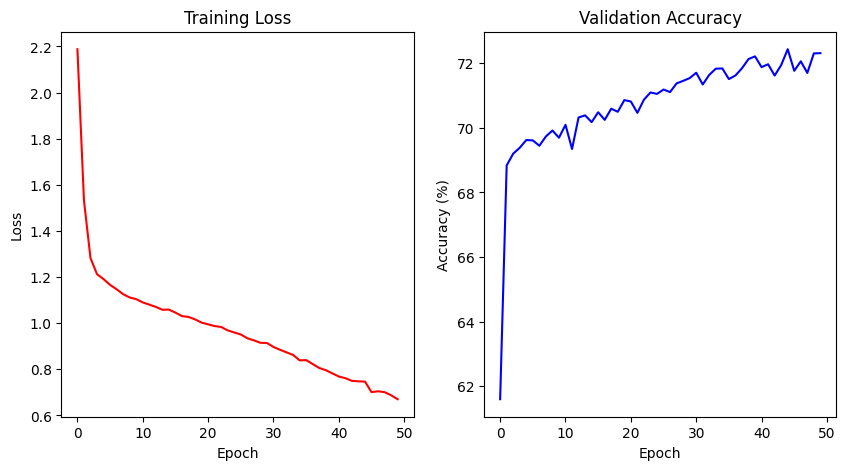

In [13]:
num_epochs = 50
train_losses = []
val_accuracies = []

for epoch in range(num_epochs ):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(cnnModel, train_loader, optimizer, loss_func, device)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')

    accuracy = validate(cnnModel, test_loader, device)
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')

plot_results(train_losses, val_accuracies)

# Evaluated some Images

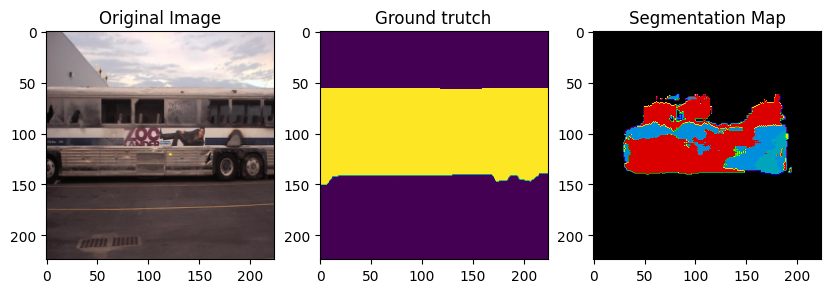

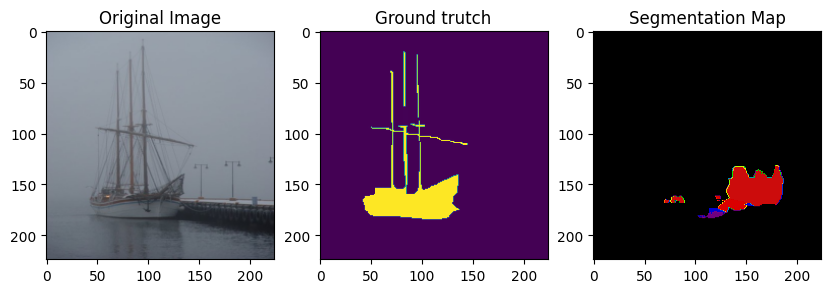

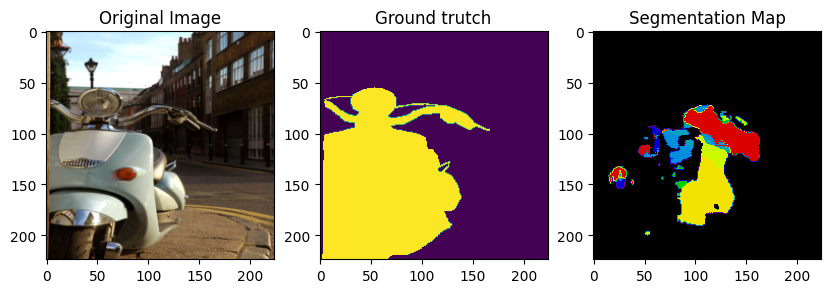

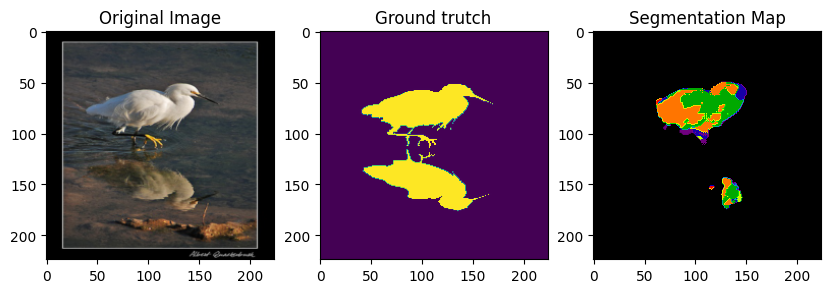

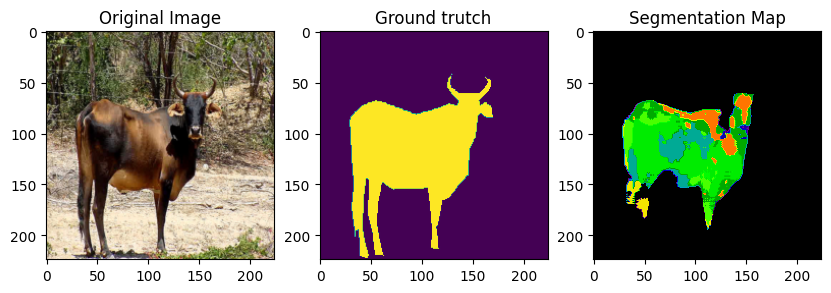

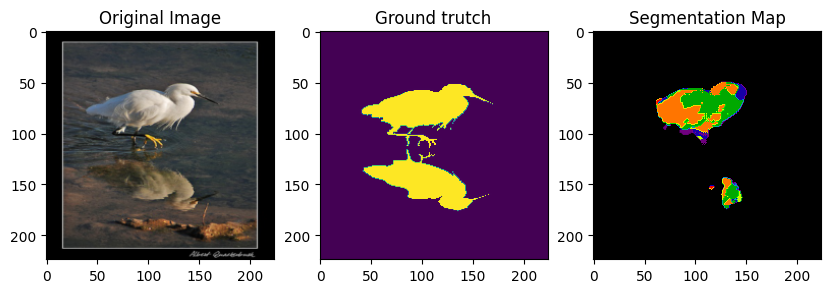

In [89]:
rand_ids = np.random.randint(1,len(test_data), 6)
def unnormalize(tensor):
    """Revert normalization on a tensor."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

cnnModel.eval()
with torch.no_grad():
    for id in rand_ids:
        image, ground_truth = test_data[id]
        image_d = image.to(device) 
        ground_truth = ground_truth.squeeze()    
#       image = image.permute(1, 2, 0)
        output = cnnModel(image_d.unsqueeze(dim=0))
        # Convert the output tensor to a segmentation map
        _, predicted = torch.max(output.data, 1)
        seg_map = predicted.squeeze().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        #convert the image and mask back to its values 0 to 255 , transform it back from .ToTensor()
        image_unnorm = unnormalize(image.clone())
        ground_truth_unnorm = transforms.ToPILImage()(ground_truth * 255)    
        
        axs[0].imshow(image_unnorm.permute(1,2,0))
        axs[0].title.set_text('Original Image')
        axs[1].imshow(ground_truth_unnorm)
        axs[1].title.set_text('Ground trutch')
        axs[2].imshow(seg_map,cmap='nipy_spectral', vmin=0, vmax=21)
        axs[2].title.set_text('Segmentation Map')
        
        plt.show()


# Save Model

In [29]:
checkpoint = {
            "state_dict": cnnModel.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
torch.save(checkpoint, "unet_cnn_voc12.pth.tar")